# Data Science Part I

"""
Imports and libs
"""
from functools import partial, reduce
from typing import List

In [99]:
import pandas as pd
import ydata_profiling
from pandas import DataFrame

In [100]:

data = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
)

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [102]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [103]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [104]:
# ydata_profiling.ProfileReport(data, title="tisernta")

In [105]:
def compose(*funcs):
    return reduce(lambda f, g: lambda x: g(f(x)), funcs, lambda x: x)

In [106]:
def fillColumNaWithMedian(data: DataFrame, columnName: str) -> DataFrame:
    columnMedian = data[columnName].median()
    return data.fillna(value={columnName: columnMedian})


def fillColumNaWithMode(data: DataFrame, columnName: str) -> DataFrame:
    columnMedian = data[columnName].mode()
    return data.fillna(value={columnName: columnMedian})


def dataDropper(data: DataFrame, columns):
    return data.drop(columns, axis=1)


from functools import partial, reduce
from typing import List

cleanAge = partial(fillColumNaWithMedian, columnName="Age")
cleanFare = partial(fillColumNaWithMedian, columnName="Fare")
cleanEmbarked = partial(fillColumNaWithMode, columnName="Embarked")
dropIrrelent = partial(dataDropper, columns=["Name", "Ticket", "Cabin"])

In [107]:
from dataclasses import dataclass


@dataclass
class NumericConversionData:
    columnName: str
    conversionMap: dict[str, int]


SexConversion = NumericConversionData("Sex", {"male": 0, "female": 1})
EmbarkedConversion = NumericConversionData("Embarked", {"C": 0, "Q": 1, "S": 2})


def convertColToNumeric(
    data: DataFrame, columnData: NumericConversionData
) -> DataFrame:
    convertedData = data.copy()
    convertedData[columnData.columnName] = data[columnData.columnName].map(columnData.conversionMap)  # type: ignore
    return convertedData


sexConverter = partial(convertColToNumeric, columnData=SexConversion)
EmbarkedConverter = partial(convertColToNumeric, columnData=EmbarkedConversion)

convertDataToNumeric = compose(sexConverter, EmbarkedConverter)
cleanData = compose(cleanAge, cleanFare, cleanEmbarked, dropIrrelent)

processedData = compose(cleanData, convertDataToNumeric)(data)

processedData

import matplotlib
import matplotlib.pyplot as plt

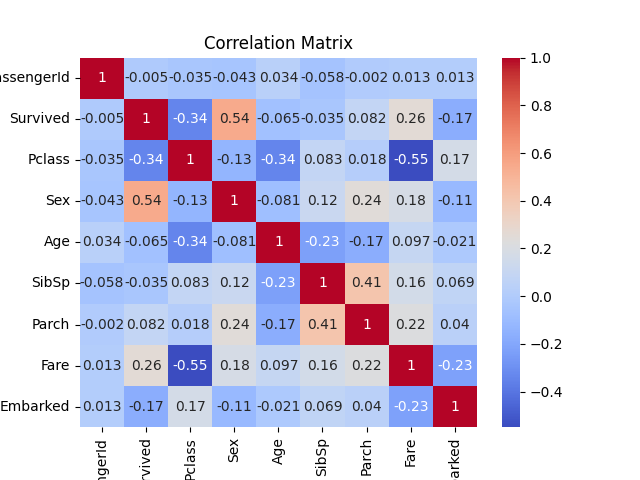

In [108]:
import seaborn as sns

matplotlib.use("ipympl")
plt.ioff()

processedDataCorrMatrix = processedData.corr().round(3)
sns.heatmap(processedDataCorrMatrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

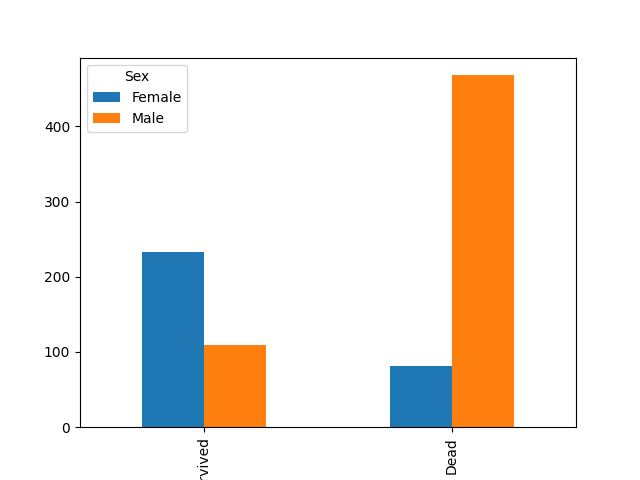

In [109]:
def survivalFrame(feature: str, df: DataFrame) -> DataFrame:
    survived = df[df["Survived"] == 1][feature].value_counts()
    dead = df[df["Survived"] == 0][feature].value_counts()
    deathFrame = DataFrame([survived, dead])
    deathFrame.index = ["Survived", "Dead"]
    return deathFrame


survivalFrame("Sex", processedData).rename(columns={1: "Female", 0: "Male"}).plot.bar()
plt.show()

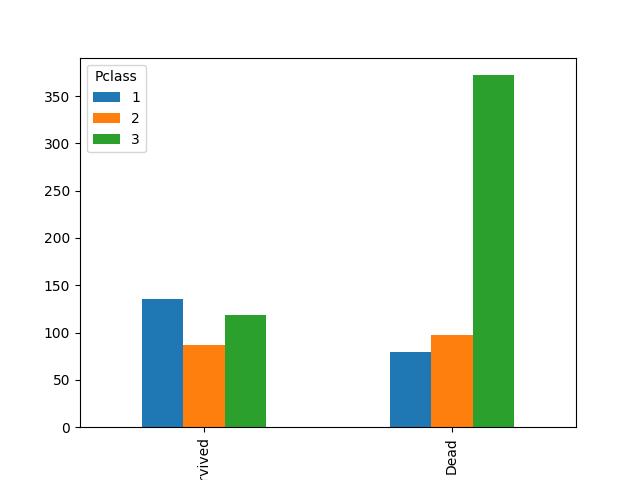

In [110]:
pclass = survivalFrame("Pclass", processedData).sort_index(axis=1)
pclass.plot.bar()
plt.show()